# Count Cars in Aerial Imagery Using Deep Learning
> - 🔬 Data Science
> - 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Get data and model for analysis](#Get-data-and-model-for-analysis)
* [Detect and count cars using ArcGIS API for Python](#Detect-and-count-cars-using-ArcGIS-API-for-Python)
* [Visualize detections on map](#Visualize-detections-on-map)
* [Visualize detections count in chart](#Visualize-detections-count-in-chart)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction 

ArcGIS provides [pretrained deep learning models](https://livingatlas.arcgis.com/en/browse/?q=dlpk#q=dlpk&d=2) that streamline the process of extracting geographic features from imagery and point cloud datasets. Tasks like manually digitizing vehicles from aerial imagery are often time-consuming and labor-intensive. Deep learning significantly reduces the need for manual work by automating feature extraction.

However, building deep learning models from scratch typically requires substantial data, computational power 🖥️, and expertise. With ArcGIS pretrained models, these challenges are eliminated. These models are trained on diverse datasets across various geographies 🌎. They are accessible through the `ArcGIS Living Atlas of the World` for users with an `ArcGIS Online` account.

One such model, 🚘 [Car Detection-USA](https://doc.arcgis.com/en/pretrained-models/latest/imagery/introduction-to-car-detection-usa.htm), is designed to identify cars in high-resolution aerial or drone imagery. This capability supports applications like traffic and parking analysis, urban planning, and economic indicator monitoring. 🚘 Car detection can even serve as a proxy for estimating retail activity or economic trends. The high spatial and temporal resolution of aerial and drone imagery makes it ideal for such analyses.

### 🎯 Objective

The objective of this notebook is to automatically detect and count cars in aerial or drone imagery using deep learning.

### 📚 What You'll Learn

By the end of this notebook, you will learn how to:
- How to search, retrieve, and apply pretrained ArcGIS deep learning models.
- How to process multiple imagery layers efficiently.
- How to detect objects (cars) using the `detect_objects()` API function.
- How to visualize results on interactive maps and charts.
- Best practices for organizing outputs and layouts in ArcGIS notebooks.

### 🧰 Tools & Technologies

- **ArcGIS API for Python**
- **ArcGIS Living Atlas pretrained models**
- **Plotly Express** for interactive charts
- **Jupyter Notebook** for an integrated GIS workflow
- **High-resolution aerial imagery** from OpenAerialMap / ArcGIS Online

### 📂 Dataset Description

- Imagery Source: OpenAerialMap
- The dataset includes high-resolution aerial images (5 cm spatial resolution) of urban and suburban areas, where vehicles are visible and can be detected using object detection models.

### 🗺️ Workflow Overview

The notebook follows a 10-step pipeline:

1. **Data Preparation**
   - Load aerial imagery from OpenAerialMap.
   - Ensure images are compatible with the Car Detection-USA deep learning model as mentioned in its item page.
   - Organize imagery items in a list for batch processing.

2. **Model Loading**
   - Access the Car Detection - USA pretrained model from ArcGIS Living Atlas.
   - Verify the model is loaded correctly.

3. **Output Naming**
   - Define a unique output prefix using datetime.
   - Include imagery titles in output names to avoid conflicts.

4. **Car Detection / Inference**
   - Apply the model to each aerial image using `detect_objects()`.
   - Configure model parameters (batch size, tile size, padding, threshold, GPU usage).
   - Capture processing duration for each image for performance tracking.

5. **Counting Cars**
   - Convert detection results to a DataFrame.
   - Count cars per image and store results in a dictionary.

6. **Publishing Feature Layers**
   - Save detection results as feature layers in ArcGIS Online or Enterprise.
   - Use consistent naming for easy retrieval.

7. **Visualization on Maps**
   - Overlay detected cars on imagery layers.
   - Apply symbology, transparency, and zoom to features.
   - Match imagery and feature layers by title.


8. **Setting Map Extent**
   - Focus maps on specific areas of interest (e.g., city blocks, parking lots).

9. **Layout and Presentation**
   - Arrange maps with labels using `VBox` and `HBox`.
   - Display maps side-by-side in a responsive layout for comparison of different sites.

10. **Statistical Visualization & Analysis**
    - Create charts to show car counts per imagery.
    - Review spatial patterns of detected vehicles.
    - Analyze spatial patterns and derive insights for applications like traffic analysis, urban planning, and economic activity monitoring.

🚀 Let’s get started by importing required modules and preparing our data!

## Necessary imports

In [1]:
# 📦 ArcGIS API for Python Imports
# ------------------------------------------------------------
# These modules are the backbone for working with spatial data,
# creating maps, and running deep learning models for object detection.
# ============================================================

import arcgis                                      # Main ArcGIS API package for spatial data, mapping, and ML tools.
from arcgis.gis import GIS                         # Connects to ArcGIS Online or Enterprise portals for accessing and managing GIS content.
from arcgis.learn import detect_objects            # Enables object detection workflows using trained deep learning models.
from arcgis.map.renderers import SimpleRenderer    # Defines how features are drawn on the map (e.g., symbol styles, colors).
from arcgis.map.symbols import (
    SimpleFillSymbolEsriSFS,                       # Class representing fill symbols for polygon geometries.
    SimpleFillSymbolStyle,                         # Enumeration of available polygon fill styles (solid, cross, diagonal, etc.).
    SimpleLineSymbolEsriSLS,                       # Class representing line symbols for polyline geometries.
    SimpleLineSymbolStyle                          # Enumeration of available line styles (solid, dash, dot, etc.).
)

# 📊 Data Analysis and Utilities
# ------------------------------------------------------------
# These libraries help handle tabular data, timestamps, and time-based operations.
# ============================================================

import pandas as pd                                # Library for data manipulation and analysis.
from datetime import datetime as dt                # Used for generating timestamps or formatting date-time values.
import time                                        # Provides time tracking and delay utilities.

# 🧰 Interactive Widgets for Notebooks
# ------------------------------------------------------------
# Used to create interactive layouts and display UI elements in notebooks.
# ============================================================

from ipywidgets import HBox, VBox, Label, Layout   # Layout widgets: HBox (horizontal), VBox (vertical), Label (text display), Layout (styling).
from IPython.display import display                # Renders widgets, maps, and HTML components in Jupyter notebook cells.

# 📈 Visualization
# ------------------------------------------------------------
# Enables interactive and high-quality charting for visual analysis.
# ============================================================

import plotly.express as px                        # Simplified interface for creating interactive Plotly visualizations.

print ("Packages import: Done")

Packages import: Done


## Connect to your GIS

Before you can access maps, layers, or run deep learning models, you need to connect to an **ArcGIS Online** or **ArcGIS Enterprise** portal using the `GIS` class from the ArcGIS API for Python.

Connection options:

#### 1. Automatic Connection (Recommended for ArcGIS Pro / Enterprise Notebooks)
If you’re already signed in to your ArcGIS account within **ArcGIS Pro** or **ArcGIS Enterprise Notebooks**, simply use:
```python
gis = GIS("home")
```

#### 2. Manual Connection (For Standalone Scripts)

If you’re using a standalone Jupyter Notebook, connect manually:
```python
gis = GIS("https://www.arcgis.com", "your_username", "your_password")
```

Replace:

- https://www.arcgis.com → your portal URL (for Enterprise users, this might differ).
- "your_username" and "your_password" → valid credentials.

📘 Reference:

See the [ArcGIS API for Python – GIS](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#gis) class documentation for full details

In [2]:
# Connect to your active ArcGIS session
# -----------------------------
gis = GIS('home')

# Verify connection by printing your username
# -----------------------------
print(f"Connected to ArcGIS as: {gis.users.me.username}")

Connected to ArcGIS as: gis_python


## Get data and model for analysis

#### 🔍 Search for Imagery and Load Model for Car Detection

Before performing any object detection or analysis, we need to access both:
- **Imagery data**—high-resolution aerial imagery layers published to `ArcGIS Online`.
- **Pretrained deep learning model**—the *Car Detection (USA)* model available in the `ArcGIS Living Atlas`.

##### 🛰️ Imagery Source
The aerial imagery used here was downloaded from **[OpenAerialMap](https://openaerialmap.org/)** and published as **tiled imagery layers** on `ArcGIS Online`.  
Each imagery layer is identified by a unique **Item ID**.

##### 🤖 Model Source
We’ll use the **Car Detection - USA** pretrained model from **ArcGIS Living Atlas**.  
Each model is identified by a unique **Item ID**.

##### 🔑 Accessing Content
- Both imagery and model items are retrieved via their **ArcGIS Online Item IDs**.  
- We enable searching **outside our organization** by setting `outside_org=True`.

### Get input imagery

##### Steps to Load Multiple Imagery Layers Using Item IDs:
1. Define a list of imagery **Item IDs**. We’re using seven aerial imagery layers for our analysis.
2. Loop through each ID to load it using `gis.content.get()`. 
3. Store successfully loaded items in a list for later processing (e.g., object detection or analysis).
4. Print a summary and preview the first successfully loaded imagery item.

---

📘 **Note:**  
If an item fails to load, the script will print an error message with the reason.  
You can verify your item IDs or check your ArcGIS account permissions if failures occur.

🔄 Starting to load imagery items...

✅ [1] Successfully loaded item: 18fa4d0c05714cf09e49dd556d71a6f9 - car_image_1
✅ [2] Successfully loaded item: b20ca3e1b2314099b4e821f326a4e47f - car_image_2
✅ [3] Successfully loaded item: 32f9d5097efa41d7b290b961c33ed285 - cars_image_3
✅ [4] Successfully loaded item: 0d13f1e5735341b182ae5cb4a7b9f376 - car_image_4e
✅ [5] Successfully loaded item: 843297c9ecde4831bbb024bf5d467aac - car_image_5e
✅ [6] Successfully loaded item: 8c90989c0a704773a1276c99a4fb2d85 - car_image_6e
✅ [7] Successfully loaded item: cf006ffec19a4deeaf3f7c867e113ac7 - car_image_7e

📦 Total imagery items loaded: 7 out of 7

🔍 Previewing first loaded item:


<Item title:"car_image_1" type:Tiled Imagery Layer owner:api_data_owner>
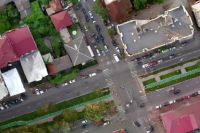

In [3]:
# 🛰️ LOAD INPUT IMAGERY FROM ARCGIS PORTAL
# ============================================================

# List of ArcGIS item IDs representing your imagery layers.
# Each ID corresponds to a raster or imagery layer hosted in ArcGIS Online or your Enterprise portal.
imagery_item_ids = [
    '18fa4d0c05714cf09e49dd556d71a6f9',   # Site 1 imagery
    'b20ca3e1b2314099b4e821f326a4e47f',   # Site 2 imagery
    '32f9d5097efa41d7b290b961c33ed285',   # Site 3 imagery
    '0d13f1e5735341b182ae5cb4a7b9f376',   # Site 4 imagery
    '843297c9ecde4831bbb024bf5d467aac',   # Site 5 imagery
    '8c90989c0a704773a1276c99a4fb2d85',   # Site 6 imagery
    'cf006ffec19a4deeaf3f7c867e113ac7'    # Site 7 imagery
]

# Initialize an empty list to hold the successfully loaded imagery items.
# This will later be used for processing or analysis.
imagery_list = []

# Print a message to indicate the start of the loading process.
print("🔄 Starting to load imagery items...\n")

# Loop through each imagery item ID and attempt to retrieve it from the GIS portal.
for idx, item_id in enumerate(imagery_item_ids, 1):  # Enumerate adds an index starting from 1 for display.
    try:
        item = gis.content.get(item_id)               # Retrieve the ArcGIS item by its unique ID.
        if item is None:                              # If no item is found, raise an explicit error.
            raise ValueError("Item returned as None")
        imagery_list.append(item)                     # Add successfully loaded item to the list.
        print(f"✅ [{idx}] Successfully loaded item: {item_id} - {item.title}")  # Confirmation message.
    except Exception as e:
        # Print a detailed error message if the item fails to load.
        print(f"❌ [{idx}] Failed to load item ID: {item_id}")
        print(f"   Reason: {str(e)}")

# Print a summary showing how many items were successfully loaded.
print(f"\n📦 Total imagery items loaded: {len(imagery_list)} out of {len(imagery_item_ids)}\n")

# If at least one item was loaded successfully, preview the first one.
# This helps confirm that imagery retrieval worked as expected.
if imagery_list:
    print("🔍 Previewing first loaded item:")
    display(imagery_list[0])  # Display the item object in the notebook (shows thumbnail and metadata).
else:
    # If no items loaded, print a warning to alert the user.
    print("⚠️ No imagery items were successfully loaded.")

### Visualize loaded imagery

It’s important to visually verify that the imagery layers were loaded correctly.

In this step, we’ll:
1. Loop through the loaded imagery list.  
2. Select a sample imagery layer (in this case, one site).  
3. Access its first layer and display it directly within the notebook.  

This helps confirm that the data is visually as expected (correct location, clarity, and tiling).

---

📘 **Note:**  
- Jupyter Notebooks automatically render imagery layers when displayed using `display(layer)`.  
- If an imagery item has multiple layers, you can adjust the code to visualize more than the first one.

🖼️ Displaying preview of one imagery layer:

📍 Site 1: car_image_2


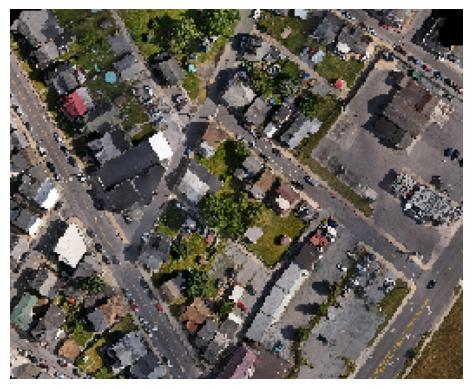

🧾 Item ID: b20ca3e1b2314099b4e821f326a4e47f



In [4]:
# 🖼️ VISUALIZE LOADED IMAGERY
# ============================================================

# Print a message indicating the start of the visualization process.
print("🖼️ Displaying preview of one imagery layer:\n")

# Loop through selected imagery items for visualization.
# Here, imagery_list[1:2] means we display only the second imagery item (index 1) for demonstration.
for i, item in enumerate(imagery_list[1:2], start=1):
    try:
        # Access the first layer of the imagery service item.
        layer = item.layers[0]

        # Print a clear label showing which site is being displayed.
        print(f"📍 Site {i}: {item.title}")

        # Display the imagery layer inline.
        # Jupyter automatically renders ArcGIS imagery layers interactively.
        display(layer)

        # Optionally, print the item ID for documentation or reuse in analysis steps.
        print(f"🧾 Item ID: {item.id}\n")

    except Exception as e:
        # If visualization fails, catch the error and print a descriptive message.
        title = item.title if item and hasattr(item, 'title') else 'Unknown'
        print(f"⚠️ Could not display Site {i}: {title} — {e}")

### Get pretrained deep learning model

#### 🔍 Search for the “Car Detection – USA” Model in ArcGIS Living Atlas

The **[Car Detection – USA](https://www.arcgis.com/home/item.html?id=cfc57b507f914d1593f5871bf0d52999)** model is a pretrained deep learning package (DLPK) from the **ArcGIS Living Atlas**, published by *Esri Analytics*.  It can detect and count vehicles from high-resolution aerial or satellite imagery. Click on the pretrained model link to know more about it.

#### 🧠 Model Search Details
- **Search String:** `"Car Detection-USA owner:esri_analytics"` — ensures we’re retrieving the official, trusted model.  
- **Item Type:** `"Deep Learning Package"` — filters the search results to deep learning models only.  
- **outside_org=True:** allows us to search for public content beyond our organization (e.g., Living Atlas models).

Once retrieved, the model item is displayed for confirmation, showing metadata and preview information in the notebook.

🔍 Searching for the pretrained 'Car Detection - USA' model...

✅ Successfully retrieved model: Car Detection - USA
📦 Item ID: cfc57b507f914d1593f5871bf0d52999



<Item title:"Car Detection - USA" type:Deep Learning Package owner:esri_analytics>
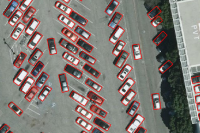

In [5]:
# 🤖 SEARCH AND LOAD THE "CAR DETECTION - USA" MODEL
# ============================================================

# 📌 Define search parameters
search_string = "Car Detection-USA owner:esri_analytics"  # Model name and trusted Esri Analytics publisher
item_type = "Deep Learning Package"                       # Limit search results to DLPK (deep learning package) items

print("🔍 Searching for the pretrained 'Car Detection - USA' model...\n")

try:
    # Perform the search in ArcGIS Online, including public (outside organization) content.
    search_results = gis.content.search(
        query=search_string,
        item_type=item_type,
        outside_org=True
    )

    # Validate that at least one result was found.
    if not search_results:
        raise LookupError("No matching model found. Please verify the model name or your access permissions.")

    # Retrieve the first (most relevant) model result.
    model = search_results[0]

    # Confirm successful retrieval and display the model card.
    print(f"✅ Successfully retrieved model: {model.title}")
    print(f"📦 Item ID: {model.id}\n")
    display(model)

except Exception as e:
    # Handle any failure gracefully and show the reason.
    print("❌ Failed to load the 'Car Detection - USA' model.")
    print(f"   Reason: {str(e)}")
    model = None  # Ensure model is set to None if loading fails

## Detect and count cars using ArcGIS API for Python

This step performs **object detection** using a **pretrained deep learning model**.

Each imagery layer is processed to:
1. Detect all visible cars using `detect_objects()` from the `ArcGIS API for Python`. This function works only on `ArcGIS Online` or `ArcGIS Enterprise`.
2. Count the total number of detected cars per image.
3. Measure the processing time for each image.

---

📘 **Tip:**  
If processing fails for an image (e.g., missing layer or GPU issue), the code will catch the error and continue with the next item instead of stopping the entire notebook.

Initialize an empty dictionary to store car counts per imagery

In [6]:
num_cars = {}

Create a timestamped prefix for all output layers. This makes it easier to find all published layers later using this prefix.

In [7]:
output_prefix = f"car_detection_{dt.now().strftime('%Y%m%d_%H%M%S')}"
print(f"🕒 Output layer prefix for this run: '{output_prefix}'\n")

🕒 Output layer prefix for this run: 'car_detection_20251029_100301'



Create a for loop to iterate through each imagery.

The detection loop is written to:

- Display duration for each imagery analysis.
- Continue processing remaining items even if one fails.
- Log detection statistics for performance analysis.

In [8]:
# Loop over each imagery item by index using enumerate
# ----------------------------------------------------------------

for i, imagery in enumerate(imagery_list):

    try:
        # Access the first raster layer of the current imagery
        raster = imagery.layers[0]
    
        # Record the start time to measure processing duration
        start_time = time.time()

        # Print beginning message 
        print(f"[{i+1}] 🚀 Starting car detection for '{imagery.title}'....")

        # Set output file name as per output prefix
        safe_title = imagery.title.replace(" ", "_")  # Replace spaces for valid names
        output_name = f"{output_prefix}_{safe_title}"
        
        # Run car detection on the raster using the pretrained model for inferencing
        detected_cars = detect_objects(
            input_raster = raster,                                                                  # Imagery to analyze
            model = model,                                                                          # Pretrained deep learning model
            output_name = output_name,   # Unique output name for each result
            model_arguments = {
                "padding": "100",                                                                   # Context padding around tiles
                "batch_size": "16",                                                                 # Batch size (adjust based on hardware)
                "threshold": "0.9",                                                                 # Confidence threshold for detections
                "return_bboxes": "False",                                                           # Return full geometry instead of just bounding boxes
                "test_time_augmentation": "True",
                "merge_policy": "mean",
                "tile_size": "400",                                                                 # Tile size for tile-based processing
            },
            context = {
                "processorType": "GPU"                                                              # Use GPU for faster processing (if available)
            },
            gis = gis
        )
    
        # Record the end time after processing is complete
        end_time = time.time()
        
        # Calculate the duration in minutes
        duration_minutes = (end_time - start_time) / 60
    
        # Print completion message with duration info
        print(f"[{i+1}] Finished detecting cars in '{imagery.title}' - Duration: {duration_minutes:.2f} minutes")
        
        # Convert detection results to a DataFrame and count the number of detections. detected_cars.query(as_df=True) converts detections to a DataFrame for easy counting.
        detections_df = detected_cars.query(as_df=True)
        num_cars[imagery.name] = len(detections_df)

        print(f"📸 {len(detections_df)} cars detected in '{imagery.title}'.")
        print ("*" * 100)

    except Exception as e:
        
        # Handle any errors during processing and print a helpful message
        title = imagery.title if imagery and hasattr(imagery, 'title') else 'Unknown'
        print(f"[{i+1}] ⚠️ Failed to process '{title}': {e}")

[1] 🚀 Starting car detection for 'car_image_1'....
[1] Finished detecting cars in 'car_image_1' - Duration: 33.39 minutes
📸 584 cars detected in 'car_image_1'.
****************************************************************************************************
[2] 🚀 Starting car detection for 'car_image_2'....
[2] Finished detecting cars in 'car_image_2' - Duration: 7.68 minutes
📸 101 cars detected in 'car_image_2'.
****************************************************************************************************
[3] 🚀 Starting car detection for 'cars_image_3'....
[3] Finished detecting cars in 'cars_image_3' - Duration: 49.15 minutes
📸 314 cars detected in 'cars_image_3'.
****************************************************************************************************
[4] 🚀 Starting car detection for 'car_image_4e'....
[4] Finished detecting cars in 'car_image_4e' - Duration: 21.52 minutes
📸 625 cars detected in 'car_image_4e'.
****************************************************

## Visualize detections on map

Now that we’ve completed object detection, let’s visualize the **detected car locations** as feature layers on the map.

##### 🔍 How It Works
- Each output from `detect_objects()` was automatically published as a **Feature Layer Collection** in ArcGIS Online.
- We’ll use the **timestamped prefix** (`output_prefix`) created earlier to find all the layers from this specific run.
- Once the layers are retrieved, we’ll visualize them in an interactive ArcGIS map.

##### 🧭 Steps
1. Use `gis.content.search()` to find all published detection layers with our prefix.  
2. Preview the retrieved feature layers.  

In [9]:
# 🔍 FETCH FEATURE LAYERS GENERATED IN THIS RUN
# ============================================================

# Confirm that the output_prefix variable exists (from previous step)
print(f"🕒 Using existing output prefix: '{output_prefix}'\n")


# Search ArcGIS Online for published feature layers
# ------------------------------------------------------------
print(f"🔎 Searching ArcGIS Online for feature layers with prefix: '{output_prefix}' ...")

features = gis.content.search(
    query=f"title:{output_prefix}",   # Search only for items created with this prefix
    item_type="Feature Layer",        # Restrict to Feature Layer results
)

# Display search results
# ------------------------------------------------------------
if not features:
    print(f"❌ No feature layers found for prefix: '{output_prefix}'")
else:
    print(f"✅ Found {len(features)} feature layer(s) matching prefix '{output_prefix}':\n")

# Display all retrieved items interactively in ArcGIS Notebook
features

🕒 Using existing output prefix: 'car_detection_20251029_100301'

🔎 Searching ArcGIS Online for feature layers with prefix: 'car_detection_20251029_100301' ...
✅ Found 7 feature layer(s) matching prefix 'car_detection_20251029_100301':



[<Item title:"car_detection_20251029_100301_cars_image_3" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_5e" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_1" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_4e" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_2" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_7e" type:Feature Layer Collection owner:arcgis_python>,
 <Item title:"car_detection_20251029_100301_car_image_6e" type:Feature Layer Collection owner:arcgis_python>]

## Define symbology for detected cars

To make the detected cars clearly visible on the map, we’ll define a custom **symbol and renderer**.

#### 🧱 Components:
- **`SimpleFillSymbolEsriSFS`**—defines the fill style and outline for polygon features.
- **`SimpleLineSymbolEsriSLS`**—defines the outline’s color, width, and style.
- **`SimpleRenderer`** — applies the same symbol to all features in the layer.

In this case:
- Detected car polygons will appear in **solid red**,  
- With a **thin red outline**,  
- Making them stand out clearly against aerial imagery.

---

📘 **Tip:**  
You can adjust the `color` or `width` values to change how the detections appear (e.g., use green `[0,255,0,255]` for easier contrast on bright imagery).

In [10]:
# 🎨 DEFINE SYMBOLOGY SETTINGS FOR DETECTED CAR LAYERS
# ============================================================

# Define the symbol style for detected cars
# -----------------------------------------
# SimpleFillSymbolEsriSFS defines a filled polygon style with an outline.
symbol = SimpleFillSymbolEsriSFS(
    outline=SimpleLineSymbolEsriSLS(
        type="esriSLS",           # Line symbol type
        style="esriSLSSolid",     # Solid line style for outlines
        color=[255, 0, 0, 255],   # RGBA: Red outline (fully opaque)
        width=1                   # Thin outline for precision
    ),
    style="esriSFSSolid"          # Solid fill style for polygons
)

# Create a renderer using the defined symbol
# ------------------------------------------
# SimpleRenderer applies the same symbol to all features in the layer.
renderer = SimpleRenderer(symbol=symbol)

# Print confirmation for clarity
print("✅ Custom symbology defined: Solid fill colour polygons with red outlines.")

✅ Custom symbology defined: Solid fill colour polygons with red outlines.


## Match and Overlay Imagery with Detected Cars

Now that we have:
- The **imagery layers** (aerial or satellite images), and  
- The **detected car feature layers** (output from our deep learning model),

We can visually overlay them on top of each other to verify detection accuracy.

##### ⚙️ How It Works
1. Loop through each imagery layer.  
2. Create an **interactive ArcGIS map** for that imagery.  
3. Search for a **matching detection layer** whose title contains the imagery title.  
4. Overlay the detection layer (using the custom red `renderer`) on top of the imagery.  
5. Store each map in a dictionary (`maps_by_image_title`) for easy access and review.

##### 🧠 Notes
- Matching is based on **title similarity**, since both imagery and feature layer names share a unique identifier (the imagery title).  
- If no matching detection layer is found, a warning is printed.  
- Each resulting map can be accessed using the imagery title key.

---

📘 **Tip:**  
If you want to display a specific map later, just run:
```python
maps_by_image_title["car_image_1"]
```
to view it interactively in your notebook.

In [11]:
# 🗺️ MATCH AND OVERLAY IMAGERY WITH DETECTED CAR LAYERS
# ============================================================

# Create a dictionary to store maps keyed by imagery title
maps_by_image_title = {}

# Loop through each imagery layer and attempt to match its detection results
# ------------------------------------------------------------
for imagery in imagery_list:
    image_title = imagery.title  # The imagery title is used for matching
    current_map = gis.map()      # Create a new empty map for this imagery

    # 🖼️ Add the base imagery layer to the map
    current_map.content.add(imagery)

    matched = False  # Track if a corresponding feature layer was added

    # Search through the fetched feature layers for a matching title
    for idx, feature_item in enumerate(features):
        if image_title in feature_item.title:
            # ✅ Add the detected car feature layer with custom renderer and slight transparency
            current_map.content.add(
                feature_item,
                drawing_info={"renderer": renderer, "transparency": 50.0}
            )

            # Automatically zoom to the detected features for better visibility
            current_map.zoom_to_layer(feature_item)
            matched = True

            # Print confirmation with index for traceability
            print(f"✅ Feature Index: {idx + 1} | Added '{feature_item.title}' with imagery '{image_title}'")
            break  # Stop searching after the first match

    # ⚠️ Handle case where no matching detection layer was found
    if not matched:
        print(f"⚠️ No matching detection layer found for imagery '{image_title}'")

    # Save the map in a dictionary for easy access by imagery title
    maps_by_image_title[image_title] = current_map

# Output summary of all generated maps
# ------------------------------------------------------------
print("\n📦 Maps created for each imagery:")

# Display dictionary (ArcGIS Notebooks render maps interactively)
maps_by_image_title

✅ Feature Index: 3 | Added 'car_detection_20251029_100301_car_image_1' with imagery 'car_image_1'
✅ Feature Index: 5 | Added 'car_detection_20251029_100301_car_image_2' with imagery 'car_image_2'
✅ Feature Index: 1 | Added 'car_detection_20251029_100301_cars_image_3' with imagery 'cars_image_3'
✅ Feature Index: 4 | Added 'car_detection_20251029_100301_car_image_4e' with imagery 'car_image_4e'
✅ Feature Index: 2 | Added 'car_detection_20251029_100301_car_image_5e' with imagery 'car_image_5e'
✅ Feature Index: 7 | Added 'car_detection_20251029_100301_car_image_6e' with imagery 'car_image_6e'
✅ Feature Index: 6 | Added 'car_detection_20251029_100301_car_image_7e' with imagery 'car_image_7e'

📦 Maps created for each imagery:


{'car_image_1': Map(),
 'car_image_2': Map(),
 'cars_image_3': Map(),
 'car_image_4e': Map(),
 'car_image_5e': Map(),
 'car_image_6e': Map(),
 'car_image_7e': Map()}

## Create Interactive Map Layout

Now that each imagery has its own map (with detections overlaid), we can visualize a few selected ones side by side for easy comparison.

##### 🧱 Layout Design
We’ll use **ipywidgets** for a responsive and elegant layout:

- **`VBox` + `Label`** — stacks a descriptive label above each map. Layout width '50%' splits the horizontal space evenly between the two VBoxes. 
- **`HBox`** — places two labeled maps side by side.  
- **`Flexbox layout`** — allows maps to resize dynamically when the notebook window changes. '1 1 auto' means: flex-grow=1, flex-shrink=1, flex-basis=auto. Padding adds space around each map to avoid a cramped appearance.
- **`VBox` (outer)** — stacks multiple rows vertically.
- **`Display`** — renders the entire widget structure in the notebook output cell.

This approach provides a **clean, organized dashboard-style layout** for comparing detection results interactively.

🖼️ Rendering interactive maps... They will update automatically below.


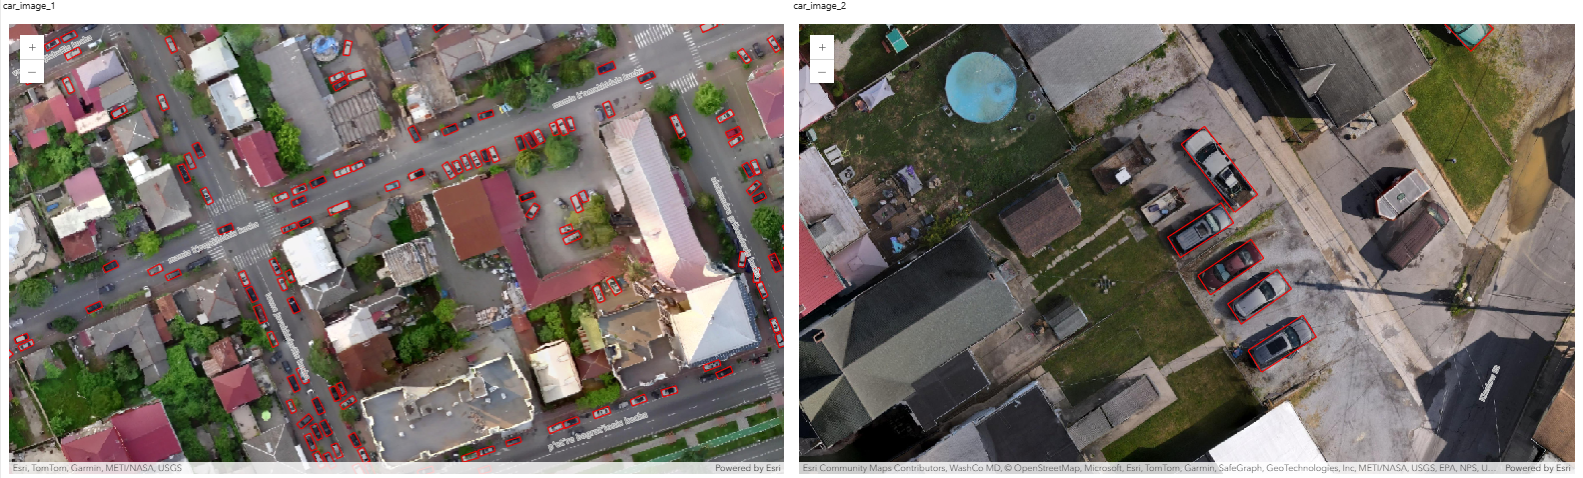

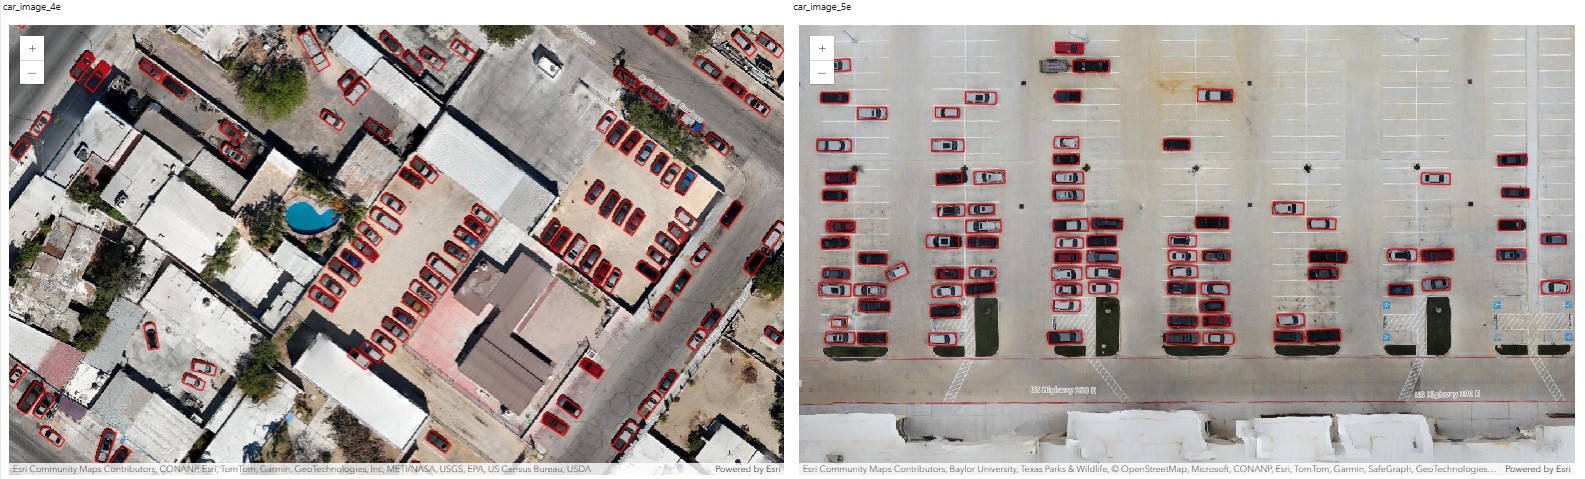

In [12]:
# 🧭 CREATE A RESPONSIVE LAYOUT TO VISUALIZE SELECTED MAPS
# ============================================================

# 🎯 SELECT MAPS TO DISPLAY
# ------------------------------------------------------------

# ✅ Get all imagery titles in the same order as imagery_list. These keys correspond to the imagery titles stored in `maps_by_image_title`
all_titles = list(maps_by_image_title.keys())

# ✅ Manually select the indexes of imagery maps to display. Adjust this list to visualize specific maps (e.g., [0, 2, 5, 6])
selected_indexes = [0, 1, 3, 4]

# ✅ Get the corresponding imagery titles using the selected indexes
selected_titles = [all_titles[i] for i in selected_indexes]

# 🧩 Create labeled VBox containers for each map widget
# ------------------------------------------------------------

map_boxes = []  # List to hold labeled map containers

for title in selected_titles:
    # Get the interactive map widget corresponding to the imagery title
    map_widget = maps_by_image_title[title]
    
    # Configure layout properties for responsiveness
    # flex='1 1 auto' → allows the map to resize dynamically
    # padding='10px' → adds spacing around maps for cleaner display
    map_widget.layout = Layout(flex='1 1 auto', padding='10px')
    
    # Create a vertical container (VBox) that stacks:
    # 1️⃣ A label (title of the imagery)
    # 2️⃣ The corresponding map widget
    # The width is set to '50%' so that two maps fit side-by-side per row
    labeled_box = VBox(
        [Label(title), map_widget],
        layout=Layout(width='50%')
    )
    
    # Append the labeled VBox to the map_boxes list
    map_boxes.append(labeled_box)

# 🧱 Arrange maps in rows using HBox (2 maps per row)
# ------------------------------------------------------------

rows = []  # List to hold horizontal containers (each row)

for i in range(0, len(map_boxes), 2):
    # Create an HBox containing two maps per row
    # map_boxes[i:i+2] slices two consecutive map boxes
    rows.append(HBox(map_boxes[i:i+2]))

# 📦 Stack all rows vertically using VBox
# This forms the final grid layout for displaying all maps
# ------------------------------------------------------------

grid_layout = VBox(rows)

# 🖼️ Display the combined layout
# ------------------------------------------------------------

# Print a status message for user clarity
print("🖼️ Rendering interactive maps... They will update automatically below.")

# Display the final grid layout in the notebook output cell
# The maps render interactively (ArcGIS API handles dynamic rendering)
display(grid_layout)

## Focus Maps on Desired Extents

To focus each map on a specific region of interest (e.g., parking lot or street block),  
you can manually define **map extents** using spatial coordinates (in WKID 102100, Web Mercator).

#### 🧭 Extent Format
Each extent dictionary includes:
- `xmin`, `ymin`, `xmax`, `ymax`: coordinates defining the visible area  
- `spatialReference`: defines the coordinate system (here, EPSG:3857)

After setting extents:
- The maps will automatically pan and zoom to those coordinates.
- You’ll see both the imagery and detected car layers aligned.

In [13]:
# 🎯 SET CUSTOM EXTENT FOR SELECTED MAPS
# ============================================================

# Set extent for the first selected imagery map
maps_by_image_title[selected_titles[0]].extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'xmin': -35441210.560145974, 'ymin': 5106518.815755455, 'xmax': -35440993.64022006, 'ymax': 5106608.390397949}

# Set extent for the second selected imagery map
maps_by_image_title[selected_titles[1]].extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'xmin': -8652429.32291009, 'ymin': 4815109.0416188985, 'xmax': -8652352.139426475, 'ymax': 4815153.828940146}

# Set extent for the third selected imagery map
maps_by_image_title[selected_titles[2]].extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'xmin': -12279856.985317225, 'ymin': 2770825.5948030218, 'xmax': -12279749.943619443, 'ymax': 2770915.169445516}

# Set extent for the fourth selected imagery map
maps_by_image_title[selected_titles[3]].extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100}, 'xmin': -10729381.319246378, 'ymin': 3521629.597541337, 'xmax': -10729271.366372716, 'ymax': 3521674.384862584}

print("✅ Custom extents have been applied to all selected maps.")
print("🗺️ You should now see each map zoomed into its defined area of interest.")

✅ Custom extents have been applied to all selected maps.
🗺️ You should now see each map zoomed into its defined area of interest.


## Review Detection Results

##### 📊 Check Number of Cars Detected in Each Imagery Layer

Now that we’ve visualized detections and focused the maps,  
let’s verify the **total number of cars** detected in each imagery layer.

This information was stored earlier in the `num_cars` dictionary.

In [14]:
num_cars  # shows number of cars detected in each imagery layer.

{'car_image_1': 584,
 'car_image_2': 101,
 'cars_image_3': 314,
 'car_image_4e': 625,
 'car_image_5e': 182,
 'car_image_6e': 26,
 'car_image_7e': 677}

## Visualize detections count in chart

Now that we’ve successfully detected cars in multiple imagery layers,  
let’s visualize the **detection results** in an interactive bar chart.

##### 📈 What this chart shows
- Each bar represents one imagery layer.  
- The height of the bar shows the **number of cars detected**.  
- The chart is interactive — you can hover over bars to see counts.

We’ll use **Plotly Express** for a clean, modern, and responsive visualization.

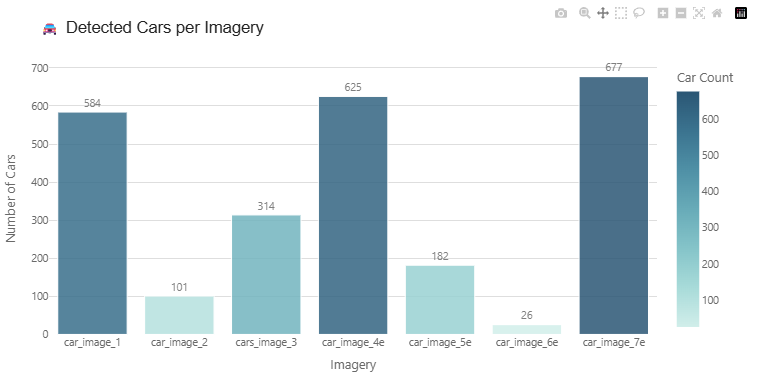

In [15]:
# 📊 VISUALIZE DETECTED CAR COUNTS USING PLOTLY
# ============================================================

# ✅ Convert the 'num_cars' dictionary into a pandas DataFrame
# Each key in 'num_cars' represents an imagery layer title (or name)
# Each value represents the number of cars detected in that imagery
car_df = pd.DataFrame(list(num_cars.items()), columns=["Imagery", "Car Count"])

# ✅ Optionally, sort the DataFrame by car count for a neater bar chart
# Uncomment this line if you want bars ordered by detection count
# car_df = car_df.sort_values("Car Count", ascending=False)

# ✅ Create an interactive bar chart using Plotly Express
# x-axis → imagery name, y-axis → detected car count
# 'text' displays car count labels on top of bars
# 'color' applies a color gradient based on car count
fig = px.bar(
    car_df,
    x="Imagery",
    y="Car Count",
    text="Car Count",
    color="Car Count",
    color_continuous_scale="teal",   # color palette for the bars
    title="🚘 Detected Cars per Imagery"  # chart title
)

# ✅ Enhance the bar chart's visual appearance
fig.update_traces(
    textposition='outside',          # Show numeric labels above bars
    marker_line_color='white',       # Add white border to bars
    marker_line_width=1.5,           # Border thickness
    opacity=0.85                     # Slight transparency for a modern look
)

# ✅ Update overall chart layout for improved readability and design
fig.update_layout(
    title_font=dict(size=22, family='Helvetica', color='#222'),  # Customize title style
    font=dict(family='Segoe UI', size=14, color='dimgray'),      # Customize font for all text
    plot_bgcolor='rgba(0,0,0,0)',                                # Transparent plotting area
    paper_bgcolor='white',                                       # White background for the figure
    xaxis_title="Imagery",                                       # Label for x-axis
    yaxis_title="Number of Cars",                                # Label for y-axis
    xaxis=dict(showgrid=False),                                  # Hide vertical grid lines
    yaxis=dict(gridcolor='lightgray'),                           # Subtle horizontal grid lines
    margin=dict(l=40, r=40, t=80, b=40),                         # Padding around the chart
    height=500,                                                  # Chart height in pixels
    width=1000,                                                  # Chart width in pixels
)

# ✅ Render the chart in the notebook
# Displays an interactive Plotly figure with hover and zoom functionality
fig.show()

## Conclusion

# 🏁 Conclusion

This notebook demonstrated how to:

1. **Connect to ArcGIS Online or Enterprise** using the ArcGIS API for Python.  
2. **Access and manage imagery layers** by referencing their Item IDs.  
3. **Retrieve and apply a pretrained deep learning model** (Car Detection – USA) from Living Atlas.  
4. **Detect and count cars** in multiple high-resolution aerial imagery layers using the `detect_objects()` function.  
5. **Visualize detection results** both spatially (on interactive maps) and quantitatively (in an interactive bar chart).  
6. **Automate batch analysis** across multiple imagery datasets using Python loops and GIS operations.  

---

### 🌍 This workflow can support real-world applications such as:

- **Urban traffic and parking analysis** – Estimating vehicle density across city blocks or parking lots.  
- **Infrastructure planning** – Assessing vehicle accumulation around new construction or transport hubs.  
- **Disaster response** – Evaluating evacuation patterns or identifying blocked roads after emergencies.  
- **Environmental monitoring** – Measuring urban sprawl and transportation impact over time.  
- **Smart city dashboards** – Integrating real-time aerial detections into operational dashboards and reports.  

---

### 🚀 Next Steps

- Expand this workflow to detect **other objects** (e.g., buildings, ships, solar panels) using pretrained or custom models.  
- Use **time-series imagery** to monitor temporal changes in car density or urban activity.  
- Deploy the notebook as part of an **automated ArcGIS workflow** or **ArcGIS Notebook Server** job for large-scale analysis.

> With just a few lines of code, we can transform raw imagery into meaningful insights that support smarter, data-driven decision-making.

## References

- Imagery from [OpenAerialMap](https://openaerialmap.org/) is licensed under [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/)